In [147]:
%pip install matplotlib
%pip install torchvision
%pip install numpy
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu
Note: you may need to restart the kernel to use updated packages.


In [148]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

In [149]:
# Check if MPS is available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [150]:
# Define the transformation to apply to the data
transform = transforms.ToTensor()

transform_train = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.85, 1.15), shear=5),
    transforms.ToTensor()
])

# Download the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False)

print("Finished downloading the MNIST dataset")

Finished downloading the MNIST dataset


torch.Size([512, 1, 28, 28])


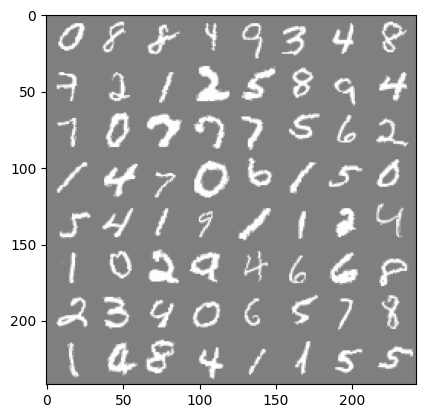

0 8 8 4 9 3 4 8


In [151]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
images = images[0:64]

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{labels[j]}' for j in range(8)))

In [152]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            # shape: (1, 28, 28)
            nn.Conv2d(1, 8, kernel_size=5),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # shape: (8, 24, 24)
            nn.MaxPool2d(kernel_size=2, stride=1),
            # shape: (8, 23, 23)
            nn.Conv2d(8, 20, kernel_size=4),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            # shape: (20, 20, 20)
            nn.MaxPool2d(kernel_size=2, stride=2),
            # shape: (20, 10, 10)
            nn.Conv2d(20, 20, kernel_size=2, stride=2),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            # shape: (20, 5, 5)
            nn.Flatten(),
            nn.Linear(20 * 5 * 5, 124),
            nn.BatchNorm1d(124),
            nn.ReLU(),
            nn.Dropout(0.25),  # Add dropout here
            nn.Linear(124, 92),
            nn.BatchNorm1d(92),
            nn.ReLU(),
            nn.Dropout(0.25),  # And here
            nn.Linear(92, 10)
        )

    def forward(self, x):
        x = self.seq(x)
        return F.log_softmax(x, dim=1)
        

net = Net().to(device)
print(net)

Net(
  (seq): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 20, kernel_size=(4, 4), stride=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(20, 20, kernel_size=(2, 2), stride=(2, 2))
    (9): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=500, out_features=124, bias=True)
    (13): BatchNorm1d(124, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.25, inplace=False)
    (16): Linear(in_features=124, out_features=92, bias=True)


In [153]:
use_saved = False

if use_saved:
    try:
        net.load_state_dict(torch.load("mnist.pth"))
        print("model loaded")
    except Exception as e:
        print(f"model not loaded ({e})")

# Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

In [158]:
#Training loop

train_losses = []
val_losses = []

num_epochs = 40

for epoch in range(num_epochs):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # calculate validation loss
    val_loss = 0.0
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    net.train()  # Set the model back to training mode
    val_loss /= len(valloader)

    # Adjust learning rate based on validation loss
    scheduler.step(val_loss)

    train_losses.append(running_loss / len(trainloader))
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / len(trainloader)}, Validation Loss: {val_loss}")

print("finished training")

Epoch 1/40, Training Loss: 0.03814737526501747, Validation Loss: 0.039324044017121196
Epoch 2/40, Training Loss: 0.041692816989218937, Validation Loss: 0.029285966845539708
Epoch 3/40, Training Loss: 0.040179981909533764, Validation Loss: 0.03101418012132247
Epoch 4/40, Training Loss: 0.039498814460920524, Validation Loss: 0.03125990585734447
Epoch 5/40, Training Loss: 0.03787970659818421, Validation Loss: 0.03016295675964405
Epoch 6/40, Training Loss: 0.0378996627306209, Validation Loss: 0.03201435956483086
Epoch 7/40, Training Loss: 0.03690583806762353, Validation Loss: 0.027871732289592426
Epoch 8/40, Training Loss: 0.03710583403230982, Validation Loss: 0.02747413209484269
Epoch 9/40, Training Loss: 0.03643526826450165, Validation Loss: 0.027205088078820456
Epoch 10/40, Training Loss: 0.038392884270387125, Validation Loss: 0.03144736549196144
Epoch 11/40, Training Loss: 0.03727767007187643, Validation Loss: 0.031208926462568343
Epoch 12/40, Training Loss: 0.03868251514839048, Valida

In [155]:
torch.save(net.state_dict(), "mnist.pth")

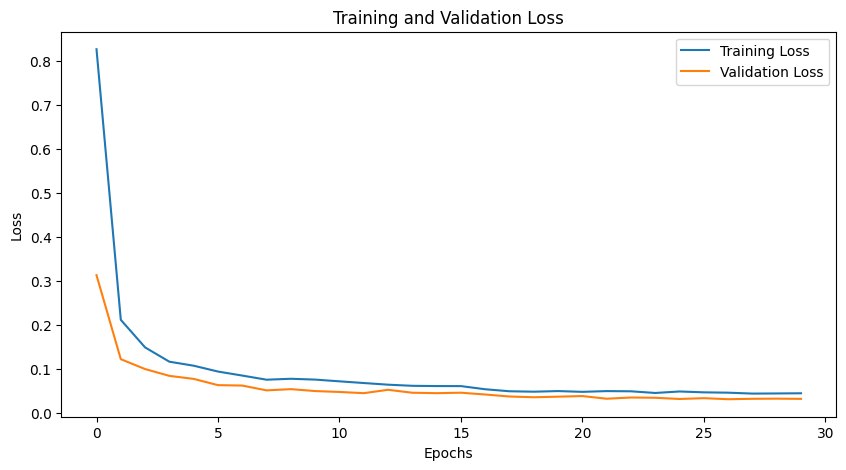

In [156]:
# plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [157]:
# Evaluate the model
correct = 0
total = 0

# No need to track gradients for evaluation
net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 99.51%
